In [6]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

style.use("fivethirtyeight")

In [4]:
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles
Map(basemap=basemap_to_tiles(
    basemaps.Esri.WorldImagery),
  center=(39.95279958991338, -75.1341365382268),
  zoom=14)

Map(center=[39.95279958991338, -75.1341365382268], controls=(ZoomControl(options=['position', 'zoom_in_text', …

Text(0.5, 1.0, 'Border Counties in New Jersey and Pennsylvania')

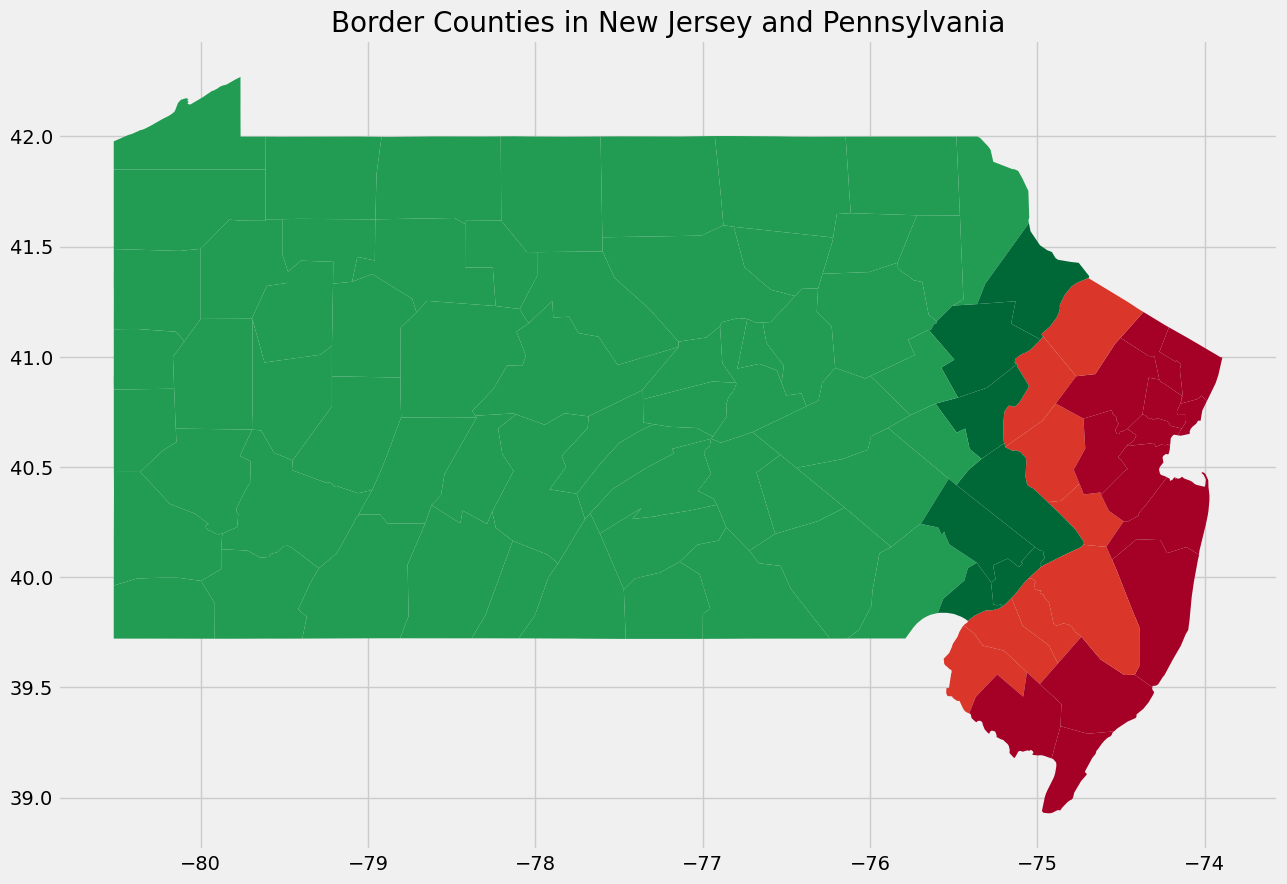

In [5]:
import geopandas as gpd

shp = gpd.read_file('https://raw.githubusercontent.com/huanfachen/DSSS/main/data/US_county/geojson-counties-fips.json') # read in the counties shapefile

subset=shp[shp['STATE'].isin(['34','42'])] # new jersey = 34, pennsylvania = 42, new york = 36
subset['neighbors']= '' # create a new column called neighbors, default at empty string

for index, row in subset.iterrows():  # iterate through each row in the counties shapefile
    buffered= row['geometry'].buffer(0.1) # create a buffer around the county so that it overlaps with its neighbors
    neighbors = list(set(subset[subset.geometry.overlaps(buffered)].STATE.tolist()).difference([row.STATE])) # check which counties overlap with the buffer, grab the state code, and remove the current county's state code
    subset.at[index, "neighbors"] = ", ".join(neighbors) # add the list of neighbors to the neighbors column

subset['border']=np.where(subset['neighbors']=='',0,1) # create a new column called border that is 1 if the county is on the border and 0 if it is not

subset['viscol']=subset['STATE'].astype(int)+subset['border'] # create a new column that combines the state code and the border column
subset.plot(column='viscol',legend=False, figsize=(20,10), cmap='RdYlGn') # plot the counties and color them by the border column
plt.title('Border Counties in New Jersey and Pennsylvania', fontsize=20) # add a title

In [7]:
# Is Alcohod killing you? Study
drinking = pd.read_csv("https://raw.githubusercontent.com/huanfachen/DSSS/main/data/drinking.csv")
drinking.head()[["agecell", "all", "mva", "suicide"]]

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


In [8]:
drinking["agecell"] -= 21

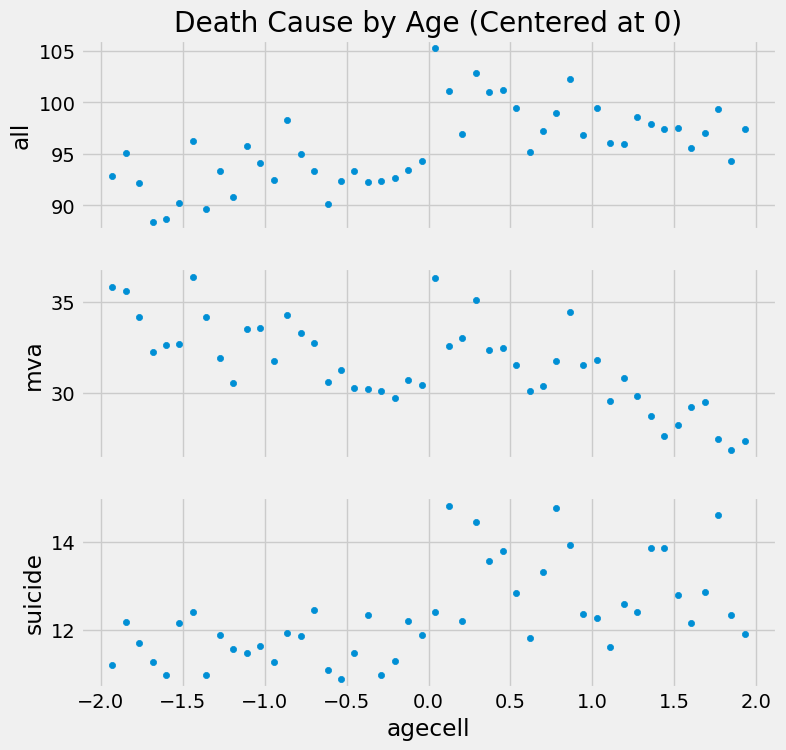

In [9]:
plt.figure(figsize=(8,8))
ax = plt.subplot(3,1,1)
drinking.plot.scatter(x="agecell", y="all", ax=ax)
plt.title("Death Cause by Age (Centered at 0)")

ax = plt.subplot(3,1,2, sharex=ax)
drinking.plot.scatter(x="agecell", y="mva", ax=ax)

ax = plt.subplot(3,1,3, sharex=ax)
drinking.plot.scatter(x="agecell", y="suicide", ax=ax);


In [10]:
# RDD Estimation
rdd_df = drinking.assign(threshold=(drinking["agecell"] > 0).astype(int))
model = smf.wls("all ~ agecell * threshold ", rdd_df).fit()
print(model.summary())

                            WLS Regression Results                            
Dep. Variable:                    all   R-squared:                       0.668
Model:                            WLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     29.47
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           1.33e-10
Time:                        09:38:59   Log-Likelihood:                -105.64
No. Observations:                  48   AIC:                             219.3
Df Residuals:                      44   BIC:                             226.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            93.6184      0.93

In [11]:
ate_pct = 100*((model.params["threshold"] + model.params["Intercept"])/model.params["Intercept"] - 1)

print("Alcohol increases the chance of death by all causes by {}%".format(np.round(ate_pct,2)))

Alcohol increases the chance of death by all causes by 8.19%


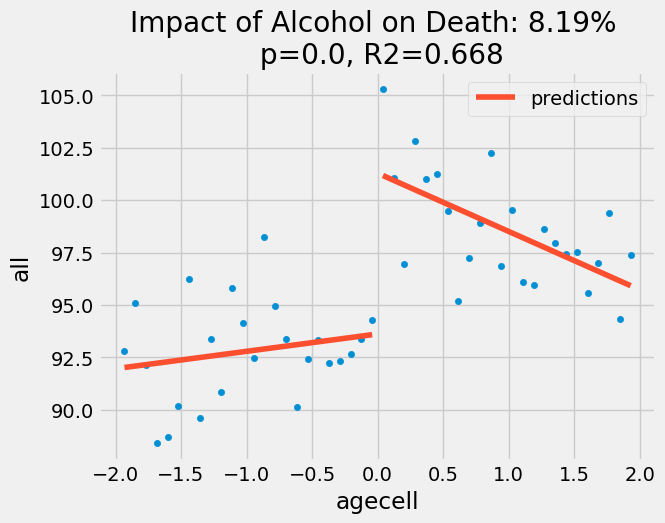

In [12]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}% \n p={np.round(model.pvalues['threshold'], 3)}, R2={np.round(model.rsquared, 3)}")
plt.show()

In [ ]:
#Now, assess the impact of drinking on motor vehicle accidents (`mva`) and suicide (`suicide`), and compare them to the impact on all-cause mortality (`all`). In each case, run a 

#Which cause of death does drinking appear to have the strongest effect on? Which model specification (e.g. linear, same slope) fits the best?


In [13]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

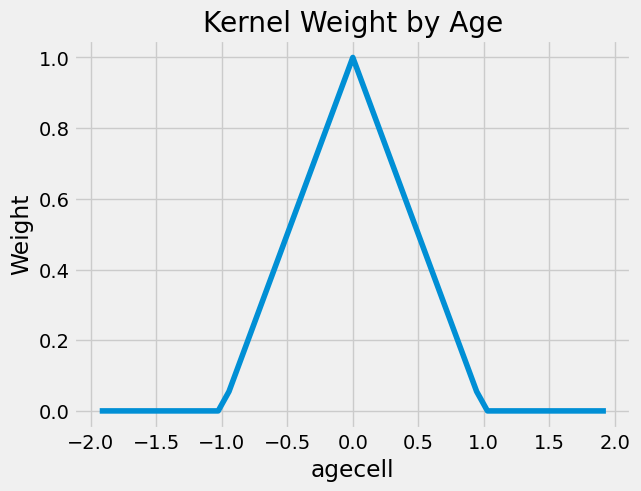

In [14]:
plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1))
plt.xlabel("agecell")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age");

In [15]:
model = smf.wls("all~agecell*threshold", rdd_df,
                weights=kernel(drinking["agecell"], c=0, h=1)).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
agecell,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
agecell:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


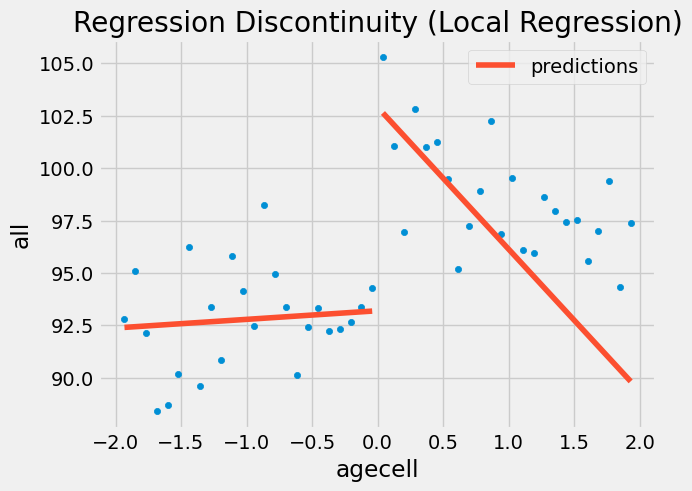

In [16]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity (Local Regression)");

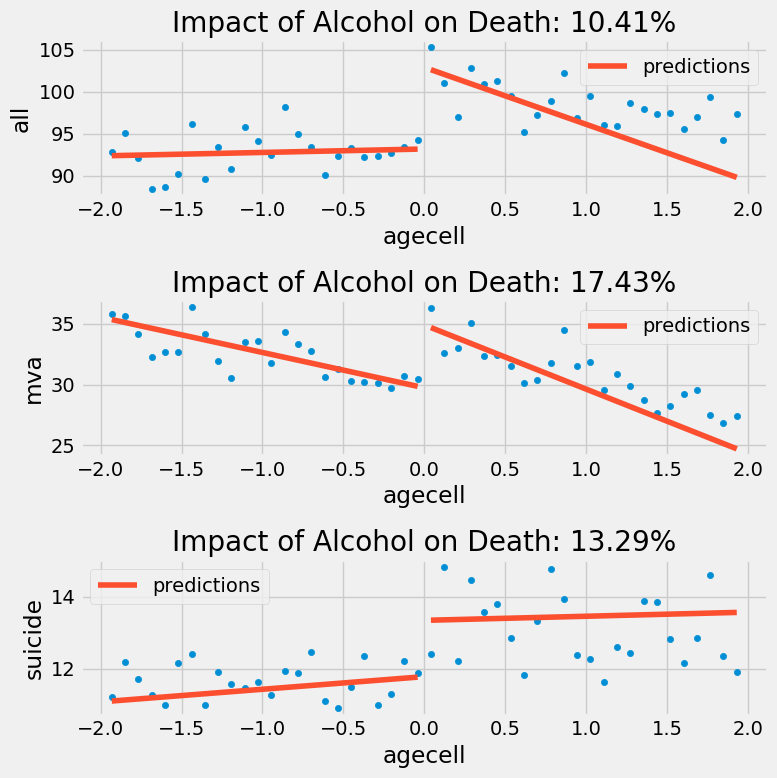

In [17]:
plt.figure(figsize=(8,8))
weights = kernel(drinking["agecell"], c=0, h=1)

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df, weights=weights).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

In [18]:
# Sheepskind effect and fuzzy RDD
sheepskin = pd.read_csv("https://raw.githubusercontent.com/huanfachen/DSSS/main/data/sheepskin.csv")[["avgearnings", "minscore", "receivehsd", "n"]]
sheepskin.head()

,avgearnings,minscore,receivehsd,n
0,11845.086,-30.0,0.416667,12
1,9205.679,-29.0,0.387097,31
2,8407.745,-28.0,0.318182,44
3,11114.087,-27.0,0.377778,45
4,10814.624,-26.0,0.306667,75


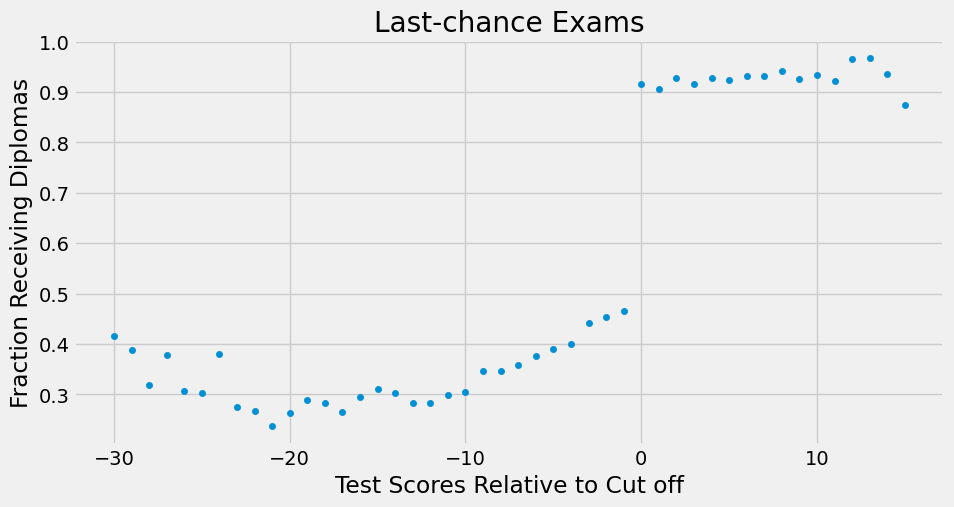

In [19]:
sheepskin.plot.scatter(x="minscore", y="receivehsd", figsize=(10,5))
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Fraction Receiving Diplomas")
plt.title("Last-chance Exams");

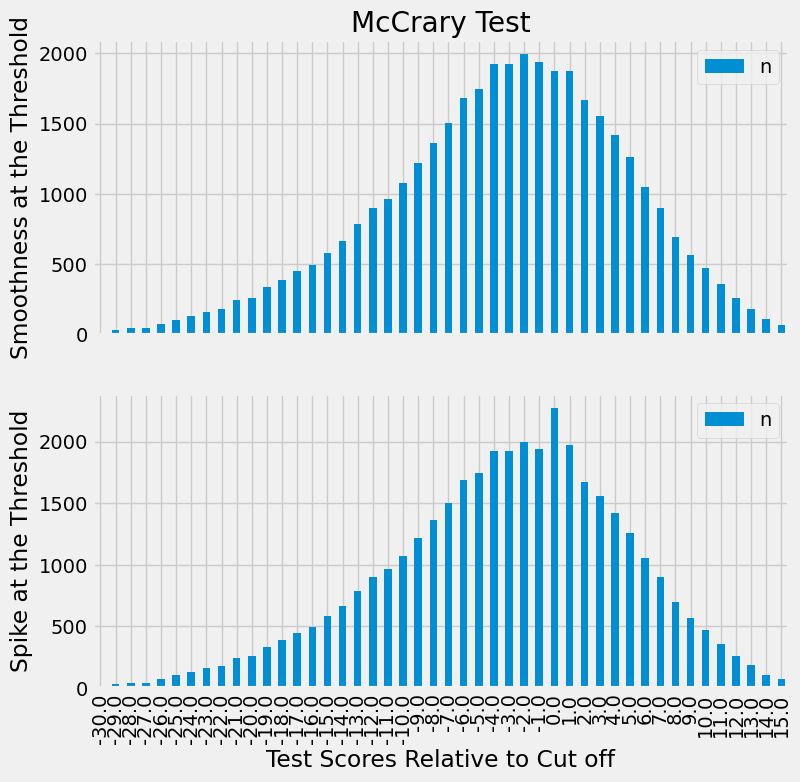

In [20]:
# MacCrary Test
plt.figure(figsize=(8,8))

ax = plt.subplot(2,1,1)
sheepskin.plot.bar(x="minscore", y="n", ax=ax)
plt.title("McCrary Test")
plt.ylabel("Smoothness at the Threshold")

ax = plt.subplot(2,1,2, sharex=ax)
sheepskin.replace({1877:1977, 1874:2277}).plot.bar(x="minscore", y="n", ax=ax)
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Spike at the Threshold");

In [21]:
sheepsking_rdd = sheepskin.assign(threshold=(sheepskin["minscore"]>0).astype(int))
model = smf.wls("avgearnings~minscore*threshold",
                sheepsking_rdd,
                weights=kernel(sheepsking_rdd["minscore"], c=0, h=15)*sheepsking_rdd["n"]).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.399e+04,83.678,167.181,0.000,1.38e+04,1.42e+04
minscore,181.6636,16.389,11.084,0.000,148.588,214.739
threshold,-97.7571,145.723,-0.671,0.506,-391.839,196.325
minscore:threshold,18.1955,30.311,0.600,0.552,-42.975,79.366


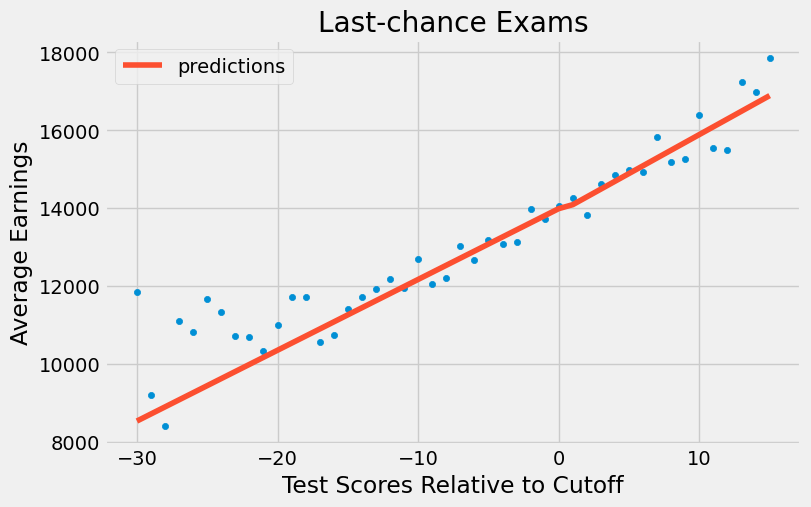

In [22]:
ax = sheepskin.plot.scatter(x="minscore", y="avgearnings", color="C0")
sheepskin.assign(predictions=model.fittedvalues).plot(x="minscore", y="predictions", ax=ax, color="C1", figsize=(8,5))
plt.xlabel("Test Scores Relative to Cutoff")
plt.ylabel("Average Earnings")
plt.title("Last-chance Exams");

In [23]:
def wald_rdd(data):
    weights=kernel(data["minscore"], c=0, h=15)*data["n"]
    denominator = smf.wls("receivehsd~minscore*threshold", data, weights=weights).fit()
    numerator = smf.wls("avgearnings~minscore*threshold", data, weights=weights).fit()
    return numerator.params["threshold"]/denominator.params["threshold"]

In [24]:
from joblib import Parallel, delayed 

np.random.seed(45)
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(wald_rdd)(sheepsking_rdd.sample(frac=1, replace=True))
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

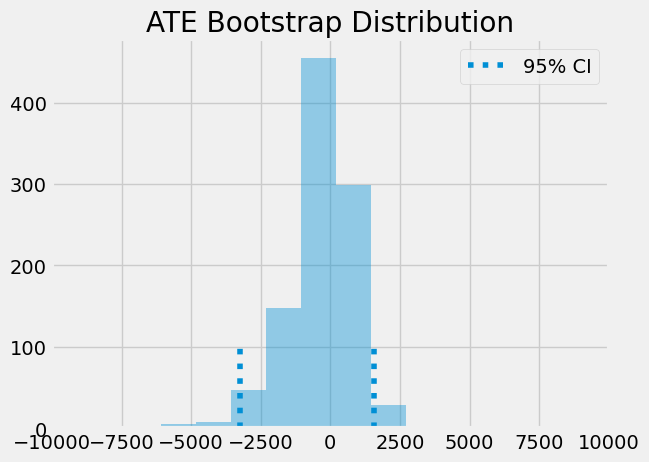

In [25]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 100, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 100, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.xlim([-10000, 10000])
plt.legend()